In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [3]:
num_samples = 1000
sample_range = range(200, 400)

Sparse Bayesian Learning (SBL)

In [4]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=1.00, beta=0.1, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [5]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(pilot_length_array)))         # HR
fr_res = np.zeros((num_samples, len(pilot_length_array)))         # FR
srr_res = np.zeros((num_samples, len(pilot_length_array)))        # SRR
precision_res = np.zeros((num_samples, len(pilot_length_array)))  # Precision
recall_res = np.zeros((num_samples, len(pilot_length_array)))     # Recall
f1_res = np.zeros((num_samples, len(pilot_length_array)))         # F1
nmse_res = np.zeros((num_samples, len(pilot_length_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and Pilot Length
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_res[sample_index, pilot_length_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, pilot_length_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, pilot_length_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index]) > 0:
            f1_res[sample_index, pilot_length_index] = (
                2 * precision_res[sample_index, pilot_length_index] * recall_res[sample_index, pilot_length_index]
                /
                (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index])
            )
        else:
            f1_res[sample_index, pilot_length_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:55<00:11, 11.41s/it]

Converged after 482 outer iterations



Processing Samples:   0%|          | 1/200 [01:01<3:25:31, 61.97s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.47s/it]

Converged after 480 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.57s/it]

Converged after 385 outer iterations



Processing Samples:   1%|          | 2/200 [01:59<3:15:29, 59.24s/it]

Converged after 286 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.97s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.87s/it]

Converged after 417 outer iterations



Processing Samples:   2%|▏         | 3/200 [02:54<3:08:52, 57.53s/it]

Converged after 295 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.50s/it]

Converged after 402 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.37s/it]

Converged after 375 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.66s/it]

Converged after 443 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.91s/it]

Converged after 451 outer iterations



Processing Samples:   2%|▎         | 5/200 [04:54<3:11:29, 58.92s/it]

Converged after 349 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:29,  9.83s/it]

Converged after 481 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.97s/it]

Converged after 376 outer iterations



Processing Samples:   3%|▎         | 6/200 [05:56<3:13:18, 59.79s/it]

Converged after 417 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:20, 10.04s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.94s/it]

Converged after 416 outer iterations



Processing Samples:   4%|▎         | 7/200 [06:56<3:12:30, 59.85s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.84s/it]

Converged after 372 outer iterations



Processing Samples:   4%|▍         | 8/200 [07:53<3:08:37, 58.94s/it]

Converged after 359 outer iterations



Processing Samples:   4%|▍         | 9/200 [08:51<3:07:07, 58.78s/it]

Converged after 253 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.00s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:29,  9.72s/it]

Converged after 464 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.25s/it]

Converged after 434 outer iterations



Processing Samples:   6%|▌         | 11/200 [10:56<3:11:08, 60.68s/it]

Converged after 428 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:28,  9.50s/it]

Converged after 473 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:18,  9.32s/it]

Converged after 398 outer iterations



Processing Samples:   6%|▌         | 12/200 [11:56<3:09:29, 60.47s/it]

Converged after 438 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.58s/it]

Converged after 492 outer iterations



Processing Samples:   6%|▋         | 13/200 [12:57<3:09:26, 60.78s/it]

Converged after 419 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.45s/it]

Converged after 486 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.71s/it]

Converged after 494 outer iterations



Processing Samples:   7%|▋         | 14/200 [13:55<3:05:54, 59.97s/it]

Converged after 315 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.54s/it]

Converged after 388 outer iterations



Processing Samples:   8%|▊         | 15/200 [14:56<3:05:03, 60.02s/it]

Converged after 440 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:30, 10.04s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.74s/it]

Converged after 492 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.67s/it]

Converged after 491 outer iterations



Processing Samples:   8%|▊         | 16/200 [15:57<3:05:01, 60.33s/it]

Converged after 364 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:37<00:18,  9.19s/it]

Converged after 378 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:47<00:09,  9.38s/it]

Converged after 406 outer iterations



Processing Samples:   8%|▊         | 17/200 [16:50<2:57:56, 58.34s/it]

Converged after 301 outer iterations



Processing Samples:   9%|▉         | 18/200 [17:54<3:01:33, 59.86s/it]

Converged after 464 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:18,  9.31s/it]

Converged after 356 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:45<00:08,  8.46s/it]

Converged after 336 outer iterations



Processing Samples:  10%|▉         | 19/200 [18:49<2:56:24, 58.48s/it]

Converged after 426 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:19,  9.92s/it]

Converged after 442 outer iterations



Processing Samples:  10%|█         | 20/200 [19:50<2:57:35, 59.20s/it]

Converged after 381 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.11s/it]

Converged after 469 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.80s/it]

Converged after 395 outer iterations



Processing Samples:  10%|█         | 21/200 [20:50<2:57:15, 59.41s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.87s/it]

Converged after 399 outer iterations



Processing Samples:  11%|█         | 22/200 [21:51<2:57:52, 59.96s/it]

Converged after 497 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:28,  9.58s/it]

Converged after 410 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:19,  9.52s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:47<00:09,  9.40s/it]

Converged after 450 outer iterations



Processing Samples:  12%|█▏        | 23/200 [22:50<2:55:49, 59.60s/it]

Converged after 473 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.65s/it]

Converged after 382 outer iterations



Processing Samples:  12%|█▏        | 24/200 [23:47<2:52:50, 58.92s/it]

Converged after 320 outer iterations



Processing Samples:  12%|█▎        | 25/200 [24:48<2:53:55, 59.63s/it]

Converged after 393 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:19,  9.67s/it]

Converged after 404 outer iterations



Processing Samples:  13%|█▎        | 26/200 [25:44<2:49:46, 58.54s/it]

Converged after 301 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:09,  9.75s/it]

Converged after 398 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:30, 10.03s/it]

Converged after 454 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:18,  9.50s/it]

Converged after 462 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:46<00:09,  9.01s/it]

Converged after 335 outer iterations



Processing Samples:  14%|█▍        | 28/200 [27:42<2:47:31, 58.44s/it]

Converged after 320 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:10, 10.04s/it]

Converged after 387 outer iterations



Processing Samples:  14%|█▍        | 29/200 [28:40<2:45:24, 58.04s/it]

Converged after 347 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.51s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.27s/it]

Converged after 388 outer iterations



Processing Samples:  15%|█▌        | 30/200 [29:39<2:45:38, 58.46s/it]

Converged after 484 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:18,  9.11s/it]

Converged after 371 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:47<00:09,  9.20s/it]

Converged after 388 outer iterations



Processing Samples:  16%|█▌        | 31/200 [30:36<2:43:47, 58.15s/it]

Converged after 400 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:11, 11.11s/it]

Converged after 492 outer iterations



Processing Samples:  16%|█▌        | 32/200 [31:40<2:47:09, 59.70s/it]

Converged after 378 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.43s/it]

Converged after 461 outer iterations



Processing Samples:  16%|█▋        | 33/200 [32:40<2:46:38, 59.87s/it]

Converged after 373 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:29,  9.90s/it]

Converged after 483 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.68s/it]

Converged after 497 outer iterations



Processing Samples:  17%|█▋        | 34/200 [33:38<2:43:58, 59.27s/it]

Converged after 317 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.65s/it]

Converged after 393 outer iterations



Processing Samples:  18%|█▊        | 35/200 [34:37<2:43:12, 59.35s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:36<00:17,  8.69s/it]

Converged after 309 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:46<00:09,  9.08s/it]

Converged after 414 outer iterations



Processing Samples:  18%|█▊        | 36/200 [35:31<2:37:38, 57.67s/it]

Converged after 350 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:20, 10.24s/it]

Converged after 383 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.35s/it]

Converged after 460 outer iterations



Processing Samples:  18%|█▊        | 37/200 [36:31<2:38:29, 58.34s/it]

Converged after 357 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.26s/it]

Converged after 489 outer iterations



Processing Samples:  19%|█▉        | 38/200 [37:32<2:39:26, 59.05s/it]

Converged after 365 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.51s/it]

Converged after 478 outer iterations



Processing Samples:  20%|█▉        | 39/200 [38:33<2:39:49, 59.56s/it]

Converged after 342 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:19, 10.00s/it]

Converged after 465 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.38s/it]

Converged after 488 outer iterations



Processing Samples:  20%|██        | 40/200 [39:33<2:39:15, 59.72s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.63s/it]

Converged after 496 outer iterations



Processing Samples:  20%|██        | 41/200 [40:33<2:38:51, 59.95s/it]

Converged after 358 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.28s/it]

Converged after 410 outer iterations



Processing Samples:  21%|██        | 42/200 [41:34<2:38:29, 60.19s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.80s/it]

Converged after 412 outer iterations



Processing Samples:  22%|██▏       | 43/200 [42:32<2:36:09, 59.68s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.54s/it]

Converged after 354 outer iterations



Processing Samples:  22%|██▏       | 44/200 [43:30<2:33:41, 59.11s/it]

Converged after 295 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.08s/it]

Converged after 414 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:47<00:09,  9.21s/it]

Converged after 297 outer iterations



Processing Samples:  23%|██▎       | 46/200 [45:30<2:32:27, 59.40s/it]

Converged after 410 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.43s/it]

Converged after 418 outer iterations



Processing Samples:  24%|██▎       | 47/200 [46:30<2:31:28, 59.40s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.09s/it]

Converged after 407 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.30s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.59s/it]

Converged after 489 outer iterations



Processing Samples:  24%|██▍       | 49/200 [48:31<2:31:09, 60.06s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:18,  9.45s/it]

Converged after 410 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.79s/it]

Converged after 453 outer iterations



Processing Samples:  25%|██▌       | 50/200 [49:30<2:28:47, 59.52s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:19,  9.56s/it]

Converged after 400 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:47<00:09,  9.28s/it]

Converged after 366 outer iterations



Processing Samples:  26%|██▌       | 51/200 [50:25<2:24:18, 58.11s/it]

Converged after 375 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.21s/it]

Converged after 387 outer iterations



Processing Samples:  26%|██▌       | 52/200 [51:24<2:24:02, 58.39s/it]

Converged after 305 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.67s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:47<00:09,  9.17s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.59s/it]

Converged after 333 outer iterations



Processing Samples:  27%|██▋       | 54/200 [53:22<2:23:21, 58.91s/it]

Converged after 440 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.57s/it]

Converged after 473 outer iterations



Processing Samples:  28%|██▊       | 55/200 [54:25<2:24:56, 59.98s/it]

Converged after 471 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.31s/it]

Converged after 423 outer iterations



Processing Samples:  28%|██▊       | 56/200 [55:23<2:22:29, 59.37s/it]

Converged after 354 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:54<00:11, 11.10s/it]

Converged after 497 outer iterations



Processing Samples:  28%|██▊       | 57/200 [56:25<2:23:26, 60.18s/it]

Converged after 368 outer iterations



Processing Samples:  29%|██▉       | 58/200 [57:27<2:23:29, 60.63s/it]

Converged after 433 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:21, 10.62s/it]

Converged after 484 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.39s/it]

Converged after 371 outer iterations



Processing Samples:  30%|██▉       | 59/200 [58:25<2:20:53, 59.96s/it]

Converged after 382 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:28<00:28,  9.47s/it]

Converged after 476 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.29s/it]

Converged after 431 outer iterations



Processing Samples:  30%|███       | 60/200 [59:24<2:19:08, 59.63s/it]

Converged after 328 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.38s/it]

Converged after 495 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.20s/it]

Converged after 426 outer iterations



Processing Samples:  30%|███       | 61/200 [1:00:23<2:17:42, 59.44s/it]

Converged after 416 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.51s/it]

Converged after 438 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.16s/it]

Converged after 412 outer iterations



Processing Samples:  31%|███       | 62/200 [1:01:21<2:15:57, 59.11s/it]

Converged after 322 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:31, 10.36s/it]

Converged after 493 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:19,  9.91s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.18s/it]

Converged after 326 outer iterations



Processing Samples:  32%|███▏      | 63/200 [1:02:19<2:14:01, 58.69s/it]

Converged after 392 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.89s/it]

Converged after 418 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.80s/it]

Converged after 412 outer iterations



Processing Samples:  32%|███▏      | 64/200 [1:03:15<2:11:13, 57.89s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09, 10.00s/it]

Converged after 439 outer iterations



Processing Samples:  32%|███▎      | 65/200 [1:04:14<2:11:10, 58.30s/it]

Converged after 332 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.82s/it]

Converged after 397 outer iterations



Processing Samples:  33%|███▎      | 66/200 [1:05:13<2:10:34, 58.47s/it]

Converged after 373 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:19,  9.73s/it]

Converged after 384 outer iterations



Processing Samples:  34%|███▎      | 67/200 [1:06:11<2:08:58, 58.18s/it]

Converged after 293 outer iterations



Processing Samples:  34%|███▍      | 68/200 [1:07:13<2:10:34, 59.35s/it]

Converged after 456 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.57s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.44s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.52s/it]

Converged after 477 outer iterations



Processing Samples:  35%|███▌      | 70/200 [1:09:14<2:09:39, 59.84s/it]

Converged after 334 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:19,  9.95s/it]

Converged after 494 outer iterations



Processing Samples:  36%|███▌      | 71/200 [1:10:13<2:08:28, 59.76s/it]

Converged after 314 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:29,  9.79s/it]

Converged after 461 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.00s/it]

Converged after 410 outer iterations



Processing Samples:  36%|███▌      | 72/200 [1:11:11<2:06:29, 59.29s/it]

Converged after 377 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.50s/it]

Converged after 455 outer iterations



Processing Samples:  36%|███▋      | 73/200 [1:12:13<2:06:49, 59.92s/it]

Converged after 466 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.46s/it]

Converged after 468 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.26s/it]

Converged after 366 outer iterations



Processing Samples:  37%|███▋      | 74/200 [1:13:12<2:05:29, 59.76s/it]

Converged after 438 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.81s/it]

Converged after 401 outer iterations



Processing Samples:  38%|███▊      | 75/200 [1:14:11<2:03:51, 59.46s/it]

Converged after 362 outer iterations



Processing Samples:  38%|███▊      | 76/200 [1:15:11<2:03:28, 59.74s/it]

Converged after 306 outer iterations



Processing Samples:  38%|███▊      | 77/200 [1:16:12<2:02:50, 59.92s/it]

Converged after 354 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:30, 10.00s/it]

Converged after 482 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:47<00:09,  9.34s/it]

Converged after 388 outer iterations



Processing Samples:  39%|███▉      | 78/200 [1:17:08<1:59:52, 58.95s/it]

Converged after 342 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.79s/it]

Converged after 395 outer iterations



Processing Samples:  40%|███▉      | 79/200 [1:18:07<1:58:51, 58.94s/it]

Converged after 371 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:19,  9.75s/it]

Converged after 420 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:10, 10.24s/it]

Converged after 487 outer iterations



Processing Samples:  40%|████      | 80/200 [1:19:06<1:57:58, 58.98s/it]

Converged after 382 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.30s/it]

Converged after 466 outer iterations



Processing Samples:  40%|████      | 81/200 [1:20:07<1:57:58, 59.48s/it]

Converged after 382 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.33s/it]

Converged after 359 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.94s/it]

Converged after 444 outer iterations



Processing Samples:  42%|████▏     | 83/200 [1:22:07<1:56:17, 59.64s/it]

Converged after 333 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:28,  9.64s/it]

Converged after 495 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.77s/it]

Converged after 444 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.89s/it]

Converged after 438 outer iterations



Processing Samples:  42%|████▏     | 84/200 [1:23:05<1:54:12, 59.07s/it]

Converged after 337 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:20, 10.10s/it]

Converged after 456 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.96s/it]

Converged after 417 outer iterations



Processing Samples:  42%|████▎     | 85/200 [1:24:02<1:52:12, 58.54s/it]

Converged after 396 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:43<00:22, 11.02s/it]

Converged after 477 outer iterations



Processing Samples:  43%|████▎     | 86/200 [1:25:05<1:53:39, 59.82s/it]

Converged after 398 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:30, 10.30s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.08s/it]

Converged after 475 outer iterations



Processing Samples:  44%|████▎     | 87/200 [1:26:05<1:52:59, 60.00s/it]

Converged after 389 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.66s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:47<00:09,  9.22s/it]

Converged after 356 outer iterations



Processing Samples:  44%|████▍     | 88/200 [1:27:03<1:50:52, 59.40s/it]

Converged after 425 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.49s/it]

Converged after 492 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.69s/it]

Converged after 344 outer iterations



Processing Samples:  44%|████▍     | 89/200 [1:28:01<1:48:57, 58.89s/it]

Converged after 392 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.19s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:46<00:08,  8.82s/it]

Converged after 319 outer iterations



Processing Samples:  45%|████▌     | 90/200 [1:28:58<1:47:09, 58.45s/it]

Converged after 447 outer iterations



Processing Samples:  46%|████▌     | 91/200 [1:30:00<1:47:44, 59.31s/it]

Converged after 327 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.68s/it]

Converged after 429 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.49s/it]

Converged after 389 outer iterations



Processing Samples:  46%|████▌     | 92/200 [1:30:57<1:45:54, 58.84s/it]

Converged after 391 outer iterations



Processing Samples:  46%|████▋     | 93/200 [1:31:57<1:45:09, 58.97s/it]

Converged after 353 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.63s/it]

Converged after 460 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.33s/it]

Converged after 461 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.47s/it]

Converged after 466 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.25s/it]

Converged after 401 outer iterations



Processing Samples:  48%|████▊     | 96/200 [1:35:04<1:45:50, 61.06s/it]

Converged after 375 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.36s/it]

Converged after 463 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:47<00:09,  9.05s/it]

Converged after 342 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:37<00:17,  8.93s/it]

Converged after 354 outer iterations



Processing Samples:  49%|████▉     | 98/200 [1:37:03<1:42:09, 60.09s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.28s/it]

Converged after 453 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:11, 11.01s/it]

Converged after 486 outer iterations



Processing Samples:  50%|█████     | 100/200 [1:39:08<1:42:19, 61.40s/it]

Converged after 381 outer iterations



Processing Samples:  50%|█████     | 101/200 [1:40:11<1:42:16, 61.98s/it]

Converged after 486 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:30, 10.26s/it]

Converged after 482 outer iterations



Processing Samples:  51%|█████     | 102/200 [1:41:11<1:39:58, 61.21s/it]

Converged after 322 outer iterations



Processing Samples:  52%|█████▏    | 103/200 [1:42:14<1:39:50, 61.76s/it]

Converged after 480 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.68s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.94s/it]

Converged after 450 outer iterations



Processing Samples:  52%|█████▏    | 104/200 [1:43:13<1:37:45, 61.10s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.54s/it]

Converged after 443 outer iterations



Processing Samples:  52%|█████▎    | 105/200 [1:44:15<1:36:52, 61.19s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.46s/it]

Converged after 467 outer iterations



Processing Samples:  53%|█████▎    | 106/200 [1:45:17<1:36:24, 61.54s/it]

Converged after 479 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:20, 10.12s/it]

Converged after 449 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.89s/it]

Converged after 403 outer iterations



Processing Samples:  54%|█████▎    | 107/200 [1:46:14<1:33:09, 60.10s/it]

Converged after 341 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.41s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.32s/it]

Converged after 459 outer iterations



Processing Samples:  54%|█████▍    | 108/200 [1:47:13<1:31:54, 59.94s/it]

Converged after 372 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.53s/it]

Converged after 432 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.31s/it]

Converged after 379 outer iterations



Processing Samples:  55%|█████▍    | 109/200 [1:48:11<1:29:37, 59.10s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.21s/it]

Converged after 407 outer iterations



Processing Samples:  55%|█████▌    | 110/200 [1:49:13<1:30:20, 60.23s/it]

Converged after 461 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.82s/it]

Converged after 369 outer iterations



Processing Samples:  56%|█████▌    | 111/200 [1:50:11<1:28:00, 59.33s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:30, 10.00s/it]

Converged after 458 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.04s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:46<00:08,  8.88s/it]

Converged after 348 outer iterations



Processing Samples:  56%|█████▌    | 112/200 [1:51:07<1:25:29, 58.29s/it]

Converged after 365 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.22s/it]

Converged after 485 outer iterations



Processing Samples:  56%|█████▋    | 113/200 [1:52:07<1:25:17, 58.82s/it]

Converged after 308 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.27s/it]

Converged after 424 outer iterations



Processing Samples:  57%|█████▋    | 114/200 [1:53:07<1:24:45, 59.14s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.13s/it]

Converged after 379 outer iterations



Processing Samples:  57%|█████▊    | 115/200 [1:54:05<1:23:36, 59.02s/it]

Converged after 343 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.67s/it]

Converged after 426 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.10s/it]

Converged after 498 outer iterations



Processing Samples:  58%|█████▊    | 116/200 [1:55:05<1:23:04, 59.34s/it]

Converged after 384 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.95s/it]

Converged after 411 outer iterations



Processing Samples:  58%|█████▊    | 117/200 [1:56:06<1:22:47, 59.85s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:19,  9.60s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.52s/it]

Converged after 386 outer iterations



Processing Samples:  59%|█████▉    | 118/200 [1:57:04<1:21:04, 59.32s/it]

Converged after 400 outer iterations



Processing Samples:  60%|█████▉    | 119/200 [1:58:08<1:21:53, 60.66s/it]

Converged after 421 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.99s/it]

Converged after 402 outer iterations



Processing Samples:  60%|██████    | 120/200 [1:59:08<1:20:40, 60.50s/it]

Converged after 437 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:19,  9.53s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.95s/it]

Converged after 466 outer iterations



Processing Samples:  60%|██████    | 121/200 [2:00:05<1:18:08, 59.34s/it]

Converged after 381 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.73s/it]

Converged after 428 outer iterations



Processing Samples:  61%|██████    | 122/200 [2:01:04<1:16:48, 59.09s/it]

Converged after 343 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.00s/it]

Converged after 468 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.68s/it]

Converged after 386 outer iterations



Processing Samples:  62%|██████▏   | 123/200 [2:02:04<1:16:11, 59.36s/it]

Converged after 456 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.37s/it]

Converged after 388 outer iterations



Processing Samples:  62%|██████▏   | 124/200 [2:03:04<1:15:39, 59.73s/it]

Converged after 356 outer iterations



Processing Samples:  62%|██████▎   | 125/200 [2:04:03<1:14:20, 59.47s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:20, 10.29s/it]

Converged after 462 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:47<00:08,  8.82s/it]

Converged after 319 outer iterations



Processing Samples:  63%|██████▎   | 126/200 [2:04:59<1:12:00, 58.39s/it]

Converged after 346 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.81s/it]

Converged after 373 outer iterations



Processing Samples:  64%|██████▎   | 127/200 [2:05:58<1:11:20, 58.64s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:19,  9.60s/it]

Converged after 388 outer iterations



Processing Samples:  64%|██████▍   | 128/200 [2:06:55<1:09:35, 57.99s/it]

Converged after 321 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.60s/it]

Converged after 440 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.70s/it]

Converged after 415 outer iterations



Processing Samples:  64%|██████▍   | 129/200 [2:07:56<1:09:43, 58.92s/it]

Converged after 440 outer iterations



Processing Samples:  65%|██████▌   | 130/200 [2:08:56<1:09:18, 59.40s/it]

Converged after 373 outer iterations



Processing Samples:  66%|██████▌   | 131/200 [2:09:57<1:08:53, 59.90s/it]

Converged after 381 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:19,  9.57s/it]

Converged after 418 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:10, 10.12s/it]

Converged after 488 outer iterations



Processing Samples:  66%|██████▌   | 132/200 [2:10:56<1:07:37, 59.67s/it]

Converged after 381 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:20, 10.03s/it]

Converged after 442 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:10, 10.17s/it]

Converged after 450 outer iterations



Processing Samples:  66%|██████▋   | 133/200 [2:11:54<1:05:47, 58.92s/it]

Converged after 355 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.66s/it]

Converged after 472 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.16s/it]

Converged after 471 outer iterations



Processing Samples:  67%|██████▋   | 134/200 [2:12:54<1:05:18, 59.37s/it]

Converged after 349 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.36s/it]

Converged after 474 outer iterations



Processing Samples:  68%|██████▊   | 135/200 [2:13:56<1:05:04, 60.06s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.72s/it]

Converged after 384 outer iterations



Processing Samples:  68%|██████▊   | 136/200 [2:14:54<1:03:25, 59.46s/it]

Converged after 361 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.34s/it]

Converged after 454 outer iterations



Processing Samples:  68%|██████▊   | 137/200 [2:15:54<1:02:49, 59.83s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.96s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.55s/it]

Converged after 373 outer iterations



Processing Samples:  69%|██████▉   | 138/200 [2:16:50<1:00:38, 58.69s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:43<00:21, 10.81s/it]

Converged after 484 outer iterations



Processing Samples:  70%|██████▉   | 139/200 [2:17:52<1:00:28, 59.49s/it]

Converged after 323 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.76s/it]

Converged after 382 outer iterations



Processing Samples:  70%|███████   | 140/200 [2:18:52<59:51, 59.86s/it]  

Converged after 479 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:18,  9.29s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.69s/it]

Converged after 451 outer iterations



Processing Samples:  70%|███████   | 141/200 [2:19:52<58:41, 59.69s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.09s/it]

Converged after 404 outer iterations



Processing Samples:  71%|███████   | 142/200 [2:20:49<56:52, 58.84s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.11s/it]

Converged after 472 outer iterations



Processing Samples:  72%|███████▏  | 143/200 [2:21:52<57:17, 60.31s/it]

Converged after 467 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.71s/it]

Converged after 499 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:53<00:10, 10.79s/it]

Converged after 494 outer iterations



Processing Samples:  72%|███████▏  | 144/200 [2:22:53<56:29, 60.53s/it]

Converged after 364 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.71s/it]

Converged after 454 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.74s/it]

Converged after 421 outer iterations



Processing Samples:  72%|███████▎  | 145/200 [2:23:52<55:02, 60.05s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.12s/it]

Converged after 479 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.17s/it]

Converged after 443 outer iterations



Processing Samples:  73%|███████▎  | 146/200 [2:24:54<54:21, 60.40s/it]

Converged after 453 outer iterations



Processing Samples:  74%|███████▎  | 147/200 [2:25:57<54:06, 61.25s/it]

Converged after 454 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.28s/it]

Converged after 456 outer iterations



Processing Samples:  74%|███████▍  | 148/200 [2:26:58<53:01, 61.19s/it]

Converged after 358 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.90s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:10, 10.11s/it]

Converged after 461 outer iterations



Processing Samples:  74%|███████▍  | 149/200 [2:27:54<50:39, 59.60s/it]

Converged after 290 outer iterations



Processing Samples:  75%|███████▌  | 150/200 [2:28:55<50:00, 60.01s/it]

Converged after 336 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:18,  9.29s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.92s/it]

Converged after 463 outer iterations



Processing Samples:  76%|███████▌  | 151/200 [2:29:54<48:46, 59.73s/it]

Converged after 388 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.98s/it]

Converged after 470 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.15s/it]

Converged after 452 outer iterations



Processing Samples:  76%|███████▌  | 152/200 [2:30:53<47:46, 59.71s/it]

Converged after 368 outer iterations



Processing Samples:  76%|███████▋  | 153/200 [2:31:54<47:01, 60.04s/it]

Converged after 307 outer iterations



Processing Samples:  78%|███████▊  | 155/200 [2:34:01<46:20, 61.80s/it]

Converged after 445 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:52<00:10, 10.61s/it]

Converged after 467 outer iterations



Processing Samples:  78%|███████▊  | 156/200 [2:35:02<44:59, 61.35s/it]

Converged after 330 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.68s/it]

Converged after 473 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.89s/it]

Converged after 406 outer iterations



Processing Samples:  79%|███████▉  | 158/200 [2:37:07<43:19, 61.88s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.58s/it]

Converged after 342 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:19,  9.62s/it]

Converged after 389 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:47<00:09,  9.51s/it]

Converged after 427 outer iterations



Processing Samples:  80%|████████  | 160/200 [2:39:06<40:16, 60.41s/it]

Converged after 460 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.66s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.58s/it]

Converged after 390 outer iterations



Processing Samples:  80%|████████  | 161/200 [2:40:05<38:57, 59.93s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.06s/it]

Converged after 401 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.50s/it]

Converged after 495 outer iterations



Processing Samples:  81%|████████  | 162/200 [2:41:05<38:03, 60.10s/it]

Converged after 334 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.46s/it]

Converged after 460 outer iterations



Processing Samples:  82%|████████▏ | 163/200 [2:42:05<36:59, 59.98s/it]

Converged after 328 outer iterations



Processing Samples:  82%|████████▏ | 164/200 [2:43:07<36:19, 60.53s/it]

Converged after 383 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.81s/it]

Converged after 408 outer iterations



Processing Samples:  83%|████████▎ | 166/200 [2:45:13<35:09, 62.05s/it]

Converged after 456 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:19,  9.98s/it]

Converged after 404 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.31s/it]

Converged after 332 outer iterations



Processing Samples:  84%|████████▎ | 167/200 [2:46:10<33:16, 60.50s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.42s/it]

Converged after 426 outer iterations



Processing Samples:  84%|████████▍ | 169/200 [2:48:16<31:42, 61.38s/it]

Converged after 410 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.70s/it]

Converged after 397 outer iterations



Processing Samples:  85%|████████▌ | 170/200 [2:49:16<30:31, 61.06s/it]

Converged after 388 outer iterations



Processing Samples:  86%|████████▌ | 171/200 [2:50:19<29:48, 61.69s/it]

Converged after 358 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.49s/it]

Converged after 382 outer iterations



Processing Samples:  86%|████████▌ | 172/200 [2:51:17<28:17, 60.62s/it]

Converged after 348 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.13s/it]

Converged after 470 outer iterations



Processing Samples:  86%|████████▋ | 173/200 [2:52:18<27:15, 60.57s/it]

Converged after 354 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:20, 10.09s/it]

Converged after 457 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.33s/it]

Converged after 467 outer iterations



Processing Samples:  87%|████████▋ | 174/200 [2:53:18<26:11, 60.45s/it]

Converged after 387 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.44s/it]

Converged after 446 outer iterations



Processing Samples:  88%|████████▊ | 175/200 [2:54:20<25:24, 60.97s/it]

Converged after 459 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:41<00:21, 10.66s/it]

Converged after 478 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.05s/it]

Converged after 377 outer iterations



Processing Samples:  88%|████████▊ | 176/200 [2:55:18<24:03, 60.13s/it]

Converged after 380 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.74s/it]

Converged after 421 outer iterations



Processing Samples:  88%|████████▊ | 177/200 [2:56:19<23:06, 60.29s/it]

Converged after 420 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.89s/it]

Converged after 434 outer iterations



Processing Samples:  89%|████████▉ | 178/200 [2:57:19<22:05, 60.27s/it]

Converged after 404 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:29<00:28,  9.65s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.92s/it]

Converged after 467 outer iterations



Processing Samples:  90%|████████▉ | 179/200 [2:58:20<21:07, 60.37s/it]

Converged after 395 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:19,  9.68s/it]

Converged after 417 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.83s/it]

Converged after 436 outer iterations



Processing Samples:  90%|█████████ | 180/200 [2:59:16<19:42, 59.15s/it]

Converged after 367 outer iterations



Processing Samples:  90%|█████████ | 181/200 [3:00:18<18:58, 59.90s/it]

Converged after 333 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.45s/it]

Converged after 399 outer iterations



Processing Samples:  91%|█████████ | 182/200 [3:01:18<17:59, 59.95s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.72s/it]

Converged after 412 outer iterations



Processing Samples:  92%|█████████▏| 183/200 [3:02:16<16:52, 59.57s/it]

Converged after 347 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.41s/it]

Converged after 453 outer iterations



Processing Samples:  92%|█████████▏| 184/200 [3:03:17<15:58, 59.90s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.22s/it]

Converged after 473 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:10, 10.23s/it]

Converged after 430 outer iterations



Processing Samples:  92%|█████████▎| 185/200 [3:04:17<14:59, 59.99s/it]

Converged after 326 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.62s/it]

Converged after 450 outer iterations



Processing Samples:  93%|█████████▎| 186/200 [3:05:18<14:01, 60.08s/it]

Converged after 368 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:30<00:30, 10.26s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.99s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.48s/it]

Converged after 492 outer iterations



Processing Samples:  94%|█████████▎| 187/200 [3:06:16<12:54, 59.56s/it]

Converged after 343 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:31<00:31, 10.62s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.05s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.34s/it]

Converged after 382 outer iterations



Processing Samples:  94%|█████████▍| 188/200 [3:07:15<11:53, 59.44s/it]

Converged after 407 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.91s/it]

Converged after 432 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.60s/it]

Converged after 378 outer iterations



Processing Samples:  94%|█████████▍| 189/200 [3:08:14<10:50, 59.18s/it]

Converged after 369 outer iterations



Processing Samples:  95%|█████████▌| 190/200 [3:09:17<10:04, 60.42s/it]

Converged after 386 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:21, 10.54s/it]

Converged after 473 outer iterations



Processing Samples:  96%|█████████▌| 191/200 [3:10:20<09:10, 61.21s/it]

Converged after 441 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.26s/it]

Converged after 454 outer iterations



Processing Samples:  96%|█████████▌| 192/200 [3:11:23<08:13, 61.74s/it]

Converged after 459 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:38<00:19,  9.67s/it]

Converged after 391 outer iterations



Processing Samples:  96%|█████████▋| 193/200 [3:12:20<07:01, 60.27s/it]

Converged after 321 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.57s/it]

Converged after 476 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:50<00:09,  9.79s/it]

Converged after 412 outer iterations



Processing Samples:  97%|█████████▋| 194/200 [3:13:20<06:01, 60.32s/it]

Converged after 422 outer iterations



Processing Samples:  98%|█████████▊| 195/200 [3:14:27<05:11, 62.25s/it]

Converged after 458 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.31s/it]

Converged after 485 outer iterations



Processing Samples:  98%|█████████▊| 196/200 [3:15:27<04:05, 61.44s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:49<00:09,  9.27s/it]

Converged after 341 outer iterations



Processing Samples:  98%|█████████▊| 197/200 [3:16:25<03:01, 60.65s/it]

Converged after 401 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:39<00:19,  9.67s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:48<00:09,  9.15s/it]

Converged after 337 outer iterations



Processing Samples:  99%|█████████▉| 198/200 [3:17:21<01:58, 59.26s/it]

Converged after 318 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:40<00:20, 10.47s/it]

Converged after 493 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [00:51<00:10, 10.56s/it]

Converged after 402 outer iterations



Processing Samples: 100%|█████████▉| 199/200 [3:18:20<00:59, 59.05s/it]

Converged after 349 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [00:42<00:21, 10.66s/it]

Converged after 461 outer iterations



Processing Samples: 100%|██████████| 200/200 [3:19:24<00:00, 59.82s/it]


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [13.14  17.745 19.57  19.81  19.96  19.955]
Avg SRR : [0.074575   0.12537515 0.16215486 0.17863747 0.18744803 0.19213328]
Avg FR  : [0.60736842 0.38315789 0.20710526 0.11131579 0.07       0.04026316]
Avg PR  : [0.10809132 0.14338962 0.16744003 0.18153488 0.18810917 0.19294172]
Avg RE  : [0.1314  0.17745 0.1957  0.1981  0.1996  0.19955]
Avg F1  : [0.11839023 0.15832457 0.18023083 0.18923091 0.19352995 0.19610305]
Avg NMSE: [0.11407326 0.06367645 0.03116022 0.01855645 0.01254507 0.009885  ]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-1000-casbl-anc-alpha-1-00-beta-0-10-snr-db-12-pilot-length-all-set-2.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length_array=pilot_length_array,
    snr_db=snr_db
)

print("All results have been saved")

All results have been saved


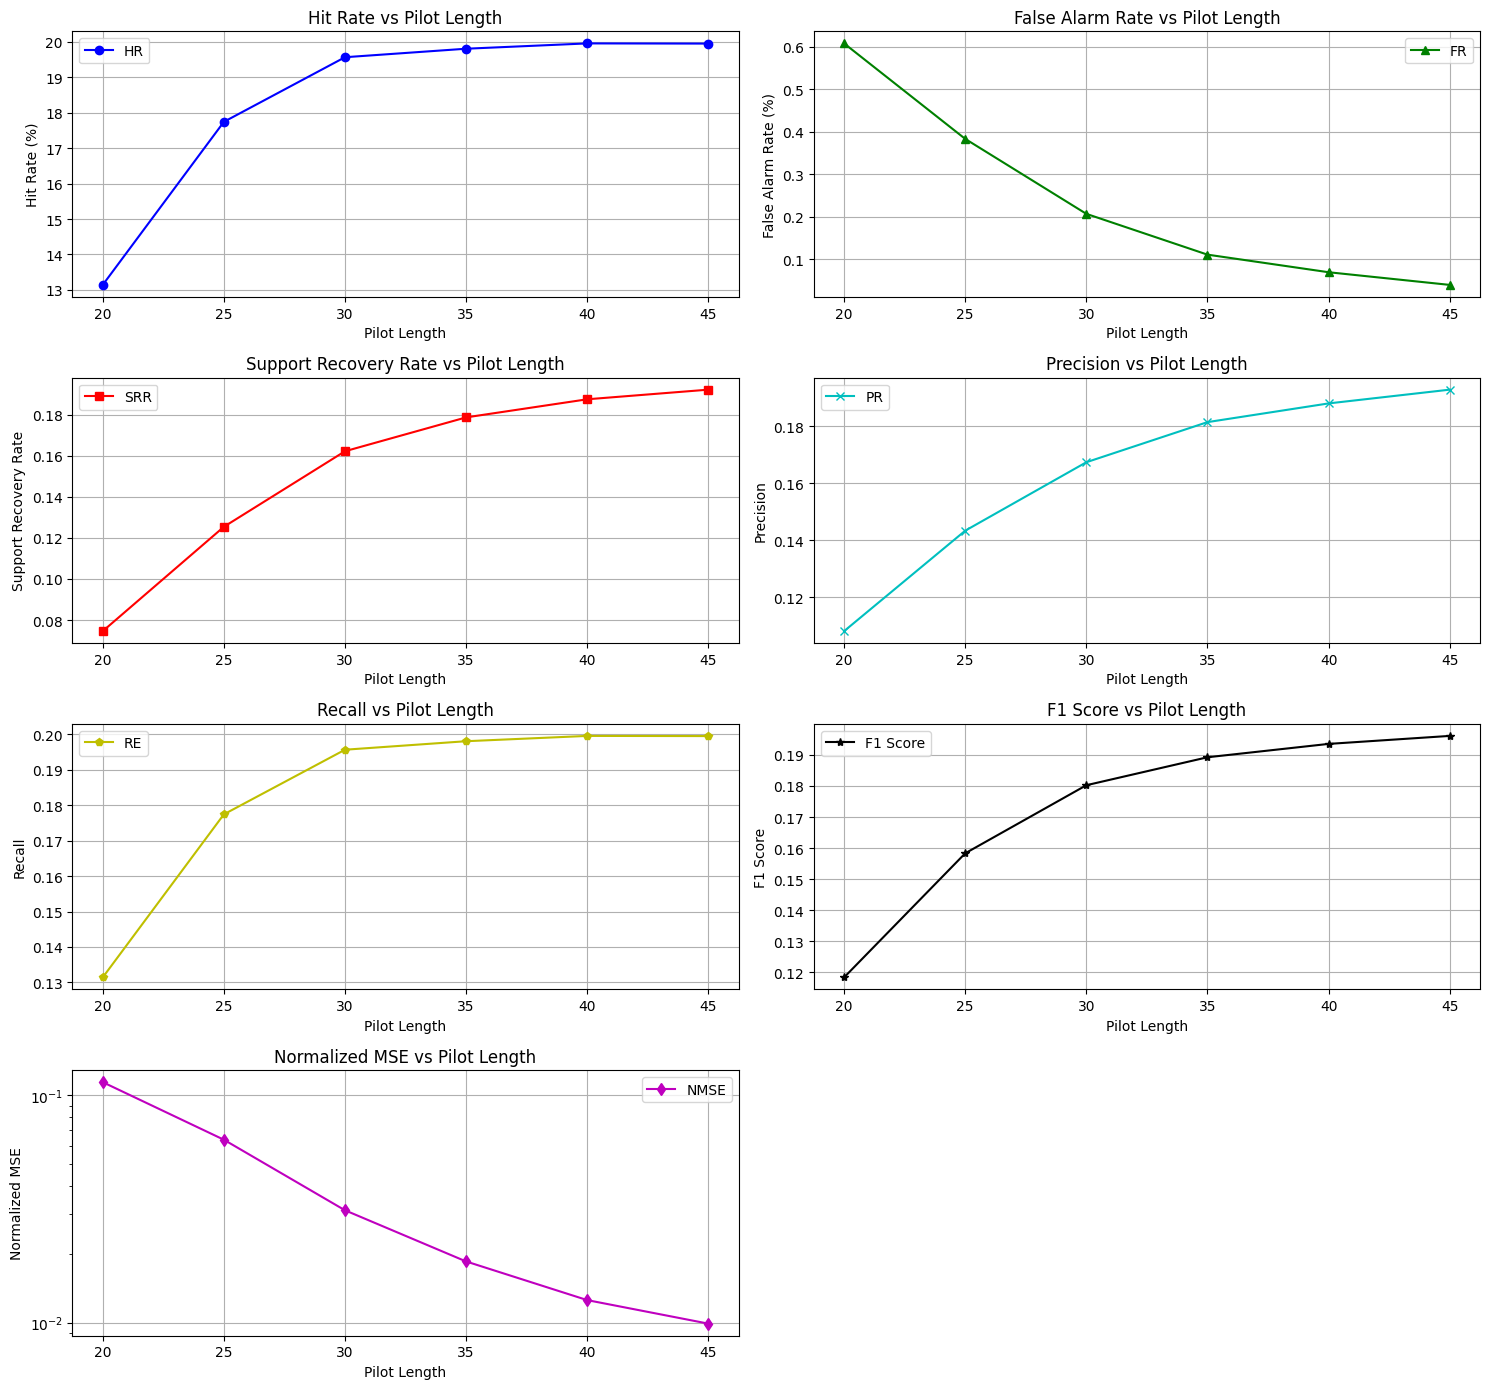

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(pilot_length_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(pilot_length_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(pilot_length_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(pilot_length_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("Pilot Length")
plt.ylabel("Precision")
plt.title("Precision vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(pilot_length_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("Pilot Length")
plt.ylabel("Recall")
plt.title("Recall vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(pilot_length_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("Pilot Length")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(pilot_length_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

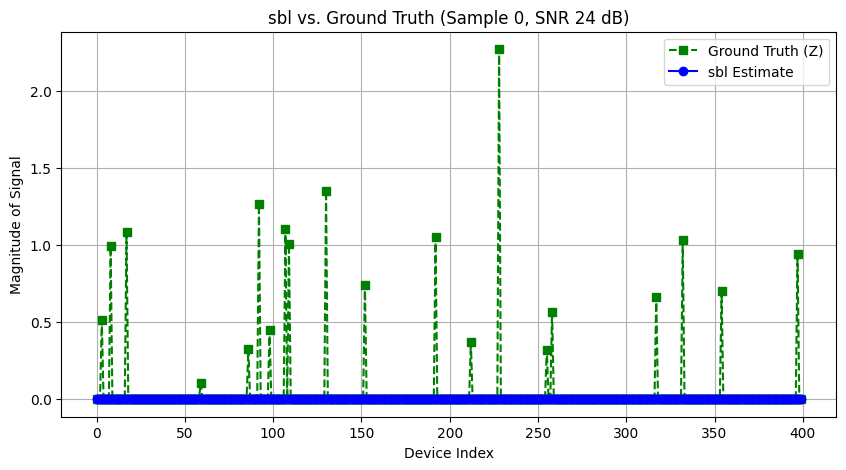

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


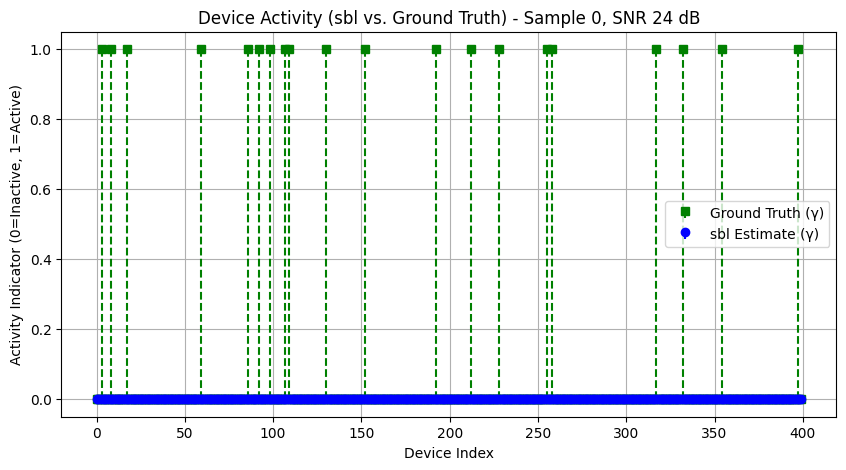

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)